In [1]:
### Bibliotecas e chamada do arquivo
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import csv
from collections import deque
from collections import defaultdict
import numpy as np

#../DdosReduzidos300.csv
## '../Data1000.csv'
###'../input/ratings.csv'
# books = pd.read_csv('../Data1000.csv', low_memory=False, delimiter=';') #o low memory é pq o arquivo é muito grande e ai o panda n precisa identificar cada variavel, se ele nao identificar ele colcoa como string, Deixa mais rapido
books = pd.read_csv('../DataFiles/Data1000.csv', low_memory=False, delimiter=',')
print(books.head(3))


   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5


In [2]:
#Remoção dos dados duplicados
books.drop_duplicates(inplace=True) 

print('temos ',books.shape[0], 'avaliações')
books.head()
##########################################

temos  1998 avaliações


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [3]:
#Selecionando as variaveis que vao ser utlizadas

books = books[['book_id', 'user_id', 'rating' ]]

print("Antes de removido \n", books.isna().sum()) 

#removendo se tivesse valores nulos
books.dropna(inplace=True)

print("Depois de removido \n", books.isna().sum()) 

#verificando a quantidade de avaliações por usuários
books['user_id'].value_counts()

#pegando os usuarios que fizeram mais de 5 avaliações
qt_rating = books['user_id'].value_counts() >= 5
y = qt_rating[qt_rating].index
y.shape

print("Usuarios selecionados: ", y)

#visualizando o tamanho do dataset
print("Dataset antes: ", books.shape)

#Pegando somente dos usuraios que avaliaram mais de 3 vezes mas agora no dataframe
books = books[books['user_id'].isin(y)]

print("Dataset depois: ", books.shape)

Antes de removido 
 book_id    0
user_id    0
rating     0
dtype: int64
Depois de removido 
 book_id    0
user_id    0
rating     0
dtype: int64
Usuarios selecionados:  Index([11927, 13282, 12874, 13794, 11691, 10140, 11692, 12946, 11945, 11854,
       ...
       36695, 37834,  3087, 13407, 21676,  5645, 13360,  6252,  8510,  8454],
      dtype='int64', name='user_id', length=166)
Dataset antes:  (1998, 3)
Dataset depois:  (1388, 3)


In [4]:
def create_user_graph(users, books):
    G = nx.Graph()
    G.add_nodes_from(users)
    
    edge_weights = defaultdict(int)  # Dicionário padrao q armazena os pesos das arestas
    
    for i, user1 in enumerate(users):
        for user2 in users[i+1:]:  # Evita comparações duplicadas
            books_user1 = set(books[books['user_id'] == user1]['book_id'])
            books_user2 = set(books[books['user_id'] == user2]['book_id'])
            common_books = books_user1.intersection(books_user2)
            if common_books:
                weight = len(common_books)
                G.add_edge(user1, user2, weight=weight)
                edge_weights[(user1, user2)] = weight #Colocando no dicicionario o peso da aresta
    
    return G, edge_weights

In [5]:
## Criação do arquivo de arestas
def save_edge_csv(edge_weights, filename):
    with open(filename, 'w', newline='') as edge_csv_file:
        cabecalho = csv.writer(edge_csv_file)
        cabecalho.writerow(['source', 'target', 'weight'])
        for (source, target), weight in edge_weights.items():
            cabecalho.writerow([source, target, weight])

In [6]:
## Criação do arquivo de nó
def save_node_csv(users, filename):
    with open(filename, 'w', newline='') as node_csv_file:
        cabecalho = csv.writer(node_csv_file)
        cabecalho.writerow(['id', 'label'])
        for user in users:
            cabecalho.writerow([user, f'User {user}'])

In [7]:
## Função para plotar o grafo
def plot_user_graph(G, edge_weights):
    pos = nx.spring_layout(G)

    node_labels = {node: str(node) for node in G.nodes()}

    # Obtenha os rótulos das arestas
    edge_labels = {edge: weight for edge, weight in edge_weights.items()}

    # Coloaca as arestas mais grossas de acordo com o peso
    edge_width = [0.1 * weight for weight in edge_weights.values()]

    #coloca com ID os nós
    nx.draw(G, pos, node_size=50, width=edge_width, with_labels=False)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

    #coloca o peso das arestas  no grafo plotado
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, font_color='red')

    plt.axis('off')
    plt.show()


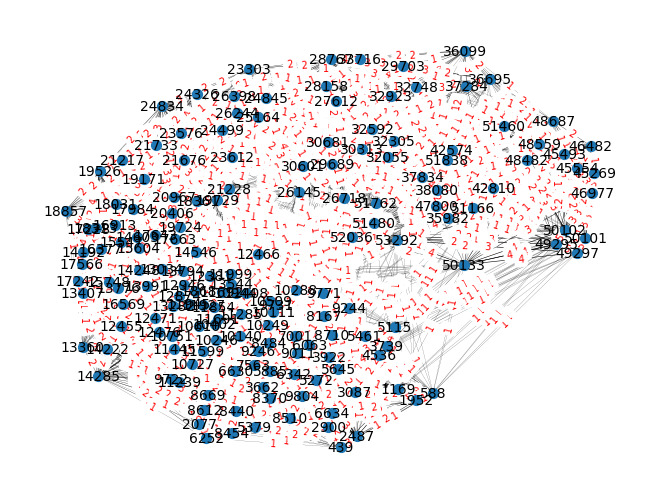

In [8]:
G, edge_weights = create_user_graph(y, books)
plot_user_graph(G, edge_weights)

In [9]:
# Funçao para calcular o coeficiente de Jaccard entre pares de nós
def jaccard_similarity(set1, set2):
    intersecao = len(set1.intersection(set2))
    uniao= len(set1.union(set2))
    if uniao != 0:
        jaccard = intersecao / uniao;
        return jaccard
    else:
        print("divisão com zero, impossivel de ser feita")

In [10]:
from collections import defaultdict

def create_user_graph_with_jaccard(users, books):
    G = nx.Graph()
    G.add_nodes_from(users)
    
    edge_weights = defaultdict(float)  # dicionario que coloca peso mas agora de acordo com jaccard
    
    user_books = defaultdict(set)

    for _, row in books.iterrows():
        user_books[row['user_id']].add(row['book_id'])

    for i, user1 in enumerate(users):
        for user2 in users[i+1:]:
            jaccard = jaccard_similarity(user_books[user1], user_books[user2])
            if jaccard > 0:
                edge_weights[(user1, user2)] = jaccard
                G.add_edge(user1, user2, weight=jaccard)
    
    return G, edge_weights


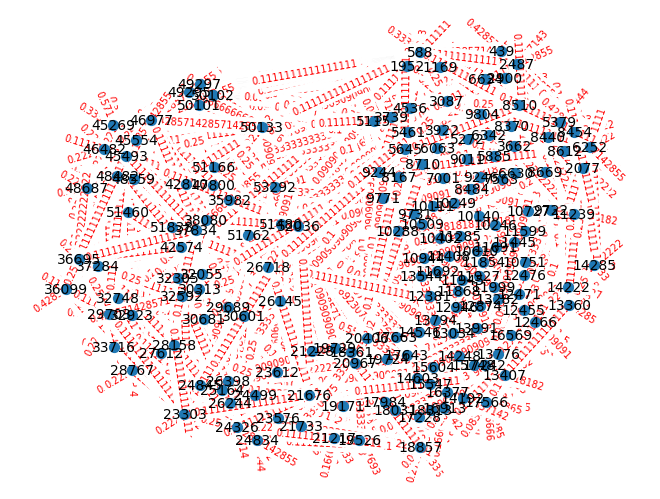

In [11]:
# Crie o grafo com coeficiente de Jaccard
graph_jaccard = G
graph_jaccard, edge_weights = create_user_graph_with_jaccard(y, books)
save_edge_csv(edge_weights, 'edge_file.csv')
save_node_csv(y, 'node_file.csv')
plot_user_graph(graph_jaccard, edge_weights)

In [12]:
def save_edges_for_gephi(edges_and_weights, filename):
    with open(filename, 'w', newline='') as edge_csv_file:
        cabecalho = csv.writer(edge_csv_file)
        cabecalho.writerow(['source', 'target', 'weight'])
        for source, target, weight in edges_and_weights:
            cabecalho.writerow([source, target, weight])

Lista de arestas da árvore geradora máxima: [(11927, 13282, 0.5142857142857142), (11927, 12946, 0.3888888888888889), (12874, 11692, 0.5185185185185185), (12874, 12946, 0.5185185185185185), (12874, 11945, 0.5), (12874, 13034, 0.4782608695652174), (12874, 11868, 0.44), (12874, 11691, 0.4), (13794, 13991, 0.4583333333333333), (13794, 15604, 0.391304347826087), (13794, 13776, 0.3181818181818182), (10140, 10111, 0.375), (10140, 9731, 0.32), (10140, 6630, 0.30434782608695654), (10140, 11999, 0.2916666666666667), (11692, 10944, 0.43478260869565216), (11692, 14546, 0.2608695652173913), (11945, 12381, 0.45454545454545453), (11854, 11408, 0.5), (11854, 12471, 0.42857142857142855), (10509, 11408, 0.5), (10509, 10249, 0.42105263157894735), (10509, 10944, 0.4), (10509, 9771, 0.29411764705882354), (10610, 10944, 0.4), (10610, 13544, 0.25), (11868, 10751, 0.3333333333333333), (11285, 11408, 0.42857142857142855), (12471, 12476, 0.3684210526315789), (5885, 2900, 0.42857142857142855), (5885, 10402, 0.29

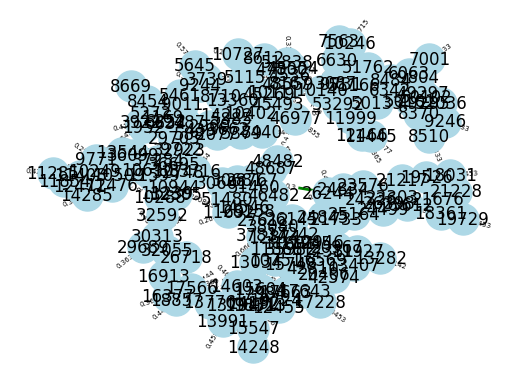

In [13]:
##MONTANDO A ARVORE GERADORA MAXIMA
GMst = graph_jaccard

maximum_spanning_tree = nx.maximum_spanning_tree(GMst, weight="weight" ,algorithm='kruskal')

edges_list = [(source, target, data['weight']) for source, target, data in maximum_spanning_tree.edges(data=True)]

save_edges_for_gephi(edges_list, 'edges_GMst_gephi.csv')
save_node_csv(maximum_spanning_tree, 'nodes_GMst.csv')

print(f"Lista de arestas da árvore geradora máxima: {edges_list}")

pos = nx.spring_layout(maximum_spanning_tree)
edge_labels = {(u, v): d["weight"] for u, v, d in maximum_spanning_tree.edges(data=True)}

nx.draw_networkx_nodes(maximum_spanning_tree, pos, node_color="lightblue", node_size=500)

nx.draw_networkx_edges(maximum_spanning_tree, pos, edge_color="green", width=2)
nx.draw_networkx_edge_labels(maximum_spanning_tree, pos, edge_labels=edge_labels, font_size=5)

node_labels = {node: node for node in maximum_spanning_tree.nodes()}
nx.draw_networkx_labels(maximum_spanning_tree, pos, labels=node_labels, font_size=12, font_family="sans-serif")

plt.axis("off")
plt.show()

In [14]:
lista = list(nx.bfs_edges(maximum_spanning_tree, source=11691))
print(f"APLICANDO BFS A PARTIR DE UM NÓ INICIAL: {lista}")

APLICANDO BFS A PARTIR DE UM NÓ INICIAL: [(11691, 12874), (12874, 11692), (12874, 12946), (12874, 11945), (12874, 13034), (12874, 11868), (11692, 10944), (11692, 14546), (12946, 11927), (11945, 12381), (13034, 14603), (11868, 10751), (10944, 10509), (10944, 10610), (11927, 13282), (14603, 14192), (14603, 17984), (14603, 17566), (10509, 11408), (10509, 10249), (10509, 9771), (10610, 13544), (14192, 15604), (14192, 15547), (14192, 12455), (17984, 17663), (17566, 18857), (17566, 16377), (17566, 16913), (11408, 11854), (11408, 11285), (15604, 13794), (15604, 15748), (15547, 14248), (17663, 17643), (11854, 12471), (13794, 13991), (13794, 13776), (15748, 16569), (15748, 17242), (17643, 20406), (17643, 17228), (17643, 19724), (12471, 12476), (16569, 13407), (20406, 20967), (19724, 18313), (19724, 19171), (12476, 11599), (12476, 14285), (20967, 21733), (11599, 9722), (11599, 11239), (11599, 10288), (21733, 26244), (9722, 2077), (9722, 6252), (26244, 23576), (26244, 24834), (26244, 24326), (262

In [15]:
def recommend_books_with_bfs(user_id, books, graph_jaccard, edge_weights):
    if user_id not in graph_jaccard.nodes():
        return []
    
    colors = {node: 'white' for node in graph_jaccard.nodes()} #colocando todos os nos como branco
    distances = {node: float('inf') for node in graph_jaccard.nodes()} #colocando as distancias como infinito
    predecessors = {node: None for node in graph_jaccard.nodes()} #colocando todos os pais/predecessores como nulo

    queue = deque([(user_id, None)])  # Cada elemento da fila agora é um par (nó, aresta)
    colors[user_id] = 'gray'
    distances[user_id] = 0

    bfs_recommendations = [] 

    while queue:
        node, edge = queue.popleft()
        similar_users = [n for n in graph_jaccard.neighbors(node)]

        for user in similar_users:
            if colors[user] == 'white':
                colors[user] = 'gray'
                distances[user] = distances[node] + 1
                predecessors[user] = node

                user_books = set(books[books['user_id'] == user]['book_id'])
                user_books2 = set(books[books['user_id'] == user_id]['book_id'])
                common_books = user_books.difference(user_books2)
                similarity = edge_weights.get((user_id, user), 0)

                for book in common_books:
                    if book not in {b for b, _ in bfs_recommendations}:
                        bfs_recommendations.append((book, similarity))

                queue.append((user, (node, user)))
        
        colors[node] = 'black'
    
    # Ordena a lista de livros com base na ordem de inserção
    bfs_recommendations.sort(key=lambda x: x[1], reverse=True)
    bfs_recommendations = [book for book, _ in bfs_recommendations]

    return bfs_recommendations

In [16]:
def list_of_books_recommended(recommended_books, num_books_to_recommend):
    dados = pd.read_csv('../inputOriginal/books.csv', delimiter=';')
    
    recommended_books = [str(book_id) for book_id in recommended_books]#conversao dos IDS para string pois estava dando erro se fosse numero
    
    dados_filtrados = dados[dados['id'].astype(str).isin(recommended_books)] #Olha as linhas do DataFrame com basse nos ID dos livros selecionados
    
    if not dados_filtrados.empty:
        for book_id in recommended_books[:num_books_to_recommend]:
            livro = dados_filtrados[dados_filtrados['id'].astype(str) == book_id]
            
            if not livro.empty:
                print(f"ID: {livro['id'].values[0]}  - Livro: {livro['original_title'].values[0]}, Autor: {livro['authors'].values[0]}")
            else:
                print(f"Livro com ID {book_id} não encontrado.")
    else:
        print("Nenhum livro recomendado encontrado.")


In [17]:
user_id_to_recommend = 11691  # O ID do usuário desejado
num_books_to_recommend = 10
recommended_books = recommend_books_with_bfs(user_id_to_recommend, books, maximum_spanning_tree, edge_weights)
if recommended_books == []: 
    print(f"Impossivel recomendar para o usuário {user_id_to_recommend} pois o mesmo não se encontra no grafo")
else:
    if len(recommended_books) == 0:
        print(f"Não ha livros para recomendar ao usuário {user_id_to_recommend}")
    else:
        print(f"Recomendações para o usuário {user_id_to_recommend}: ")
        # print(recommended_books)
        list_of_books_recommended(recommended_books, num_books_to_recommend)

Recomendações para o usuário 11691: 
ID: 100  - Livro: The Poisonwood Bible, Autor: Barbara Kingsolver
ID: 14  - Livro: Animal Farm: A Fairy Story, Autor: George Orwell
ID: 86  - Livro: A Time to Kill, Autor: John Grisham
ID: 58  - Livro: The Adventures of Huckleberry Finn, Autor: Mark Twain, John Seelye, Guy Cardwell
ID: 30  - Livro: Gone Girl, Autor: Gillian Flynn
ID: 38  - Livro: The Time Traveler's Wife, Autor: Audrey Niffenegger
ID: 89  - Livro: The Princess Bride, Autor: William Goldman
ID: 97  - Livro: Dracula, Autor: Bram Stoker, Nina Auerbach, David J. Skal
ID: 18  - Livro: Harry Potter and the Prisoner of Azkaban, Autor: J.K. Rowling, Mary GrandPré, Rufus Beck
ID: 54  - Livro: The Hitchhiker's Guide to the Galaxy, Autor: Douglas Adams
